## Paper Reading Analysis - Code Implementation
### Sanity Check Experiments
### Jonathan Alcineus

In [1]:
# These handle the file locations and importing the dataframe from the saved datafile from the authors files
import os
import pandas as pd


# These handle the image processing, editing, or displaying that needs to be performed
import cv2 
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import skimage

# These handle training the convolutional neural network (CNN) model
import tensorflow as tf
import keras
import numpy as np
import sklearn
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras.models import Model, load_model
from keras.optimizers import Adam, SGD

import copy

2025-09-03 01:31:11.045338: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-03 01:31:11.385231: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756863071.466962    3971 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756863071.490847    3971 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756863071.662859    3971 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:

# This changes the home directory
home_directory = os.path.expanduser("~")
os.chdir(home_directory)

# Then goes to the folder where the data lies
os.chdir('DNNorDermatologist')

# Ensures that we are in the correct folder
print(os.getcwd())

# Open the dataframe for the photos that are in the zip file
loaded_df = pd.read_pickle('NvAndMelNoDuplicatesFullSize.zip')


/teamspace/studios/this_studio/DNNorDermatologist


In [3]:
# GradCAM and Kernel SHAP Experiments
os.chdir(home_directory)
os.chdir('paper-reading-analysis')

# Library with the methods that I needed
import gradcam_shap
import scipy

from skimage.metrics import structural_similarity as ssim
import glob

from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

/home/zeus/miniconda3/envs/cloudspace/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
path_dict = {}

print(os.getcwd())

for i in [7, 8, 10]:
    path_dict[i] = glob.glob('Explanations_ModelSearch2_Seed_{}/*.png'.format(i),recursive=True)

/teamspace/studios/this_studio/paper-reading-analysis


In [12]:
path_frame = pd.DataFrame.from_dict(path_dict)

In [ ]:

for i in path_dict.keys():
    image_list = []
    path_list = path_frame[i].tolist()
    for j in path_list:
        image_list.append(np.asarray(cv2.cvtColor(cv2.imread(j), cv2.COLOR_BGR2RGB)))
    path_frame['Folder_{}_image'.format(i)] = image_list

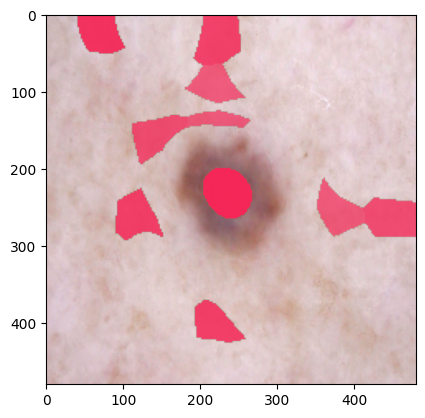

In [22]:
for image in path_frame['Folder_7_image']:
    plt.imshow(image)

In [23]:
path_frame.head()

,7,8,10,Folder_7_image,Folder_8_image,Folder_10_image
0,Explanations_ModelSearch2_Seed_7/id_155_Grad.png,Explanations_ModelSearch2_Seed_8/id_155_Grad.png,Explanations_ModelSearch2_Seed_10/id_155_Grad.png,"[[[89, 73, 156], [89, 72, 156], [88, 72, 154],...","[[[89, 73, 156], [89, 72, 156], [88, 72, 154],...","[[[89, 135, 220], [89, 134, 219], [88, 132, 21..."
1,Explanations_ModelSearch2_Seed_7/id_155_SHAP.png,Explanations_ModelSearch2_Seed_8/id_155_SHAP.png,Explanations_ModelSearch2_Seed_10/id_155_SHAP.png,"[[[193, 168, 199], [192, 167, 199], [191, 166,...","[[[193, 168, 199], [192, 167, 199], [191, 166,...","[[[193, 168, 199], [192, 167, 199], [191, 166,..."
2,Explanations_ModelSearch2_Seed_7/id_234_Grad.png,Explanations_ModelSearch2_Seed_8/id_234_Grad.png,Explanations_ModelSearch2_Seed_10/id_234_Grad.png,"[[[64, 58, 130], [64, 58, 130], [64, 58, 129],...","[[[191, 131, 67], [191, 132, 66], [191, 133, 6...","[[[64, 58, 130], [64, 58, 130], [64, 58, 129],..."
3,Explanations_ModelSearch2_Seed_7/id_234_SHAP.png,Explanations_ModelSearch2_Seed_8/id_234_SHAP.png,Explanations_ModelSearch2_Seed_10/id_234_SHAP.png,"[[[154, 144, 158], [154, 144, 157], [154, 144,...","[[[154, 144, 158], [154, 144, 157], [154, 144,...","[[[154, 144, 158], [154, 144, 157], [154, 144,..."
4,Explanations_ModelSearch2_Seed_7/id_287_Grad.png,Explanations_ModelSearch2_Seed_8/id_287_Grad.png,Explanations_ModelSearch2_Seed_10/id_287_Grad.png,"[[[95, 48, 113], [95, 48, 113], [97, 50, 112],...","[[[95, 48, 113], [95, 48, 113], [97, 50, 112],...","[[[158, 48, 50], [158, 48, 50], [162, 50, 49],..."


In [25]:
for a in [7,8,10]:
    path_frame['SSIM_7_to_{}'.format(a)] = np.nan

In [26]:
ssim(path_frame['Folder_7_image'][0], path_frame['Folder_7_image'][0], win_size = 3)

np.float64(1.0)

In [27]:
#Calculate SSIM's between all 3 models

for i in path_frame.index:
    for j in [7, 8, 10]:
        path_frame['SSIM_5_to_{}'.format(j)][i] = ssim(path_frame['Folder_7_image'][i], path_frame['Folder_{}_image'.format(j)][i],
                                                       win_size=3, multichannel = True, use_sample_covariance = True)

/tmp/ipykernel_49746/827682703.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  path_frame['SSIM_5_to_{}'.format(j)][i] = ssim(path_frame['Folder_7_image'][i], path_frame['Folder_{}_image'.format(j)][i],
/tmp/ipykernel_49746/827682703.py:

In [28]:
path_frame.head()

,7,8,10,Folder_7_image,Folder_8_image,Folder_10_image,SSIM_5_to_7,SSIM_5_to_8,SSIM_5_to_10,SSIM_7_to_7,SSIM_7_to_8,SSIM_7_to_10
0,Explanations_ModelSearch2_Seed_7/id_155_Grad.png,Explanations_ModelSearch2_Seed_8/id_155_Grad.png,Explanations_ModelSearch2_Seed_10/id_155_Grad.png,"[[[89, 73, 156], [89, 72, 156], [88, 72, 154],...","[[[89, 73, 156], [89, 72, 156], [88, 72, 154],...","[[[89, 135, 220], [89, 134, 219], [88, 132, 21...",1.0,0.261955,0.027079,NaN,NaN,NaN
1,Explanations_ModelSearch2_Seed_7/id_155_SHAP.png,Explanations_ModelSearch2_Seed_8/id_155_SHAP.png,Explanations_ModelSearch2_Seed_10/id_155_SHAP.png,"[[[193, 168, 199], [192, 167, 199], [191, 166,...","[[[193, 168, 199], [192, 167, 199], [191, 166,...","[[[193, 168, 199], [192, 167, 199], [191, 166,...",1.0,0.742751,0.713024,NaN,NaN,NaN
2,Explanations_ModelSearch2_Seed_7/id_234_Grad.png,Explanations_ModelSearch2_Seed_8/id_234_Grad.png,Explanations_ModelSearch2_Seed_10/id_234_Grad.png,"[[[64, 58, 130], [64, 58, 130], [64, 58, 129],...","[[[191, 131, 67], [191, 132, 66], [191, 133, 6...","[[[64, 58, 130], [64, 58, 130], [64, 58, 129],...",1.0,-0.001644,0.391571,NaN,NaN,NaN
3,Explanations_ModelSearch2_Seed_7/id_234_SHAP.png,Explanations_ModelSearch2_Seed_8/id_234_SHAP.png,Explanations_ModelSearch2_Seed_10/id_234_SHAP.png,"[[[154, 144, 158], [154, 144, 157], [154, 144,...","[[[154, 144, 158], [154, 144, 157], [154, 144,...","[[[154, 144, 158], [154, 144, 157], [154, 144,...",1.0,0.772717,0.777921,NaN,NaN,NaN
4,Explanations_ModelSearch2_Seed_7/id_287_Grad.png,Explanations_ModelSearch2_Seed_8/id_287_Grad.png,Explanations_ModelSearch2_Seed_10/id_287_Grad.png,"[[[95, 48, 113], [95, 48, 113], [97, 50, 112],...","[[[95, 48, 113], [95, 48, 113], [97, 50, 112],...","[[[158, 48, 50], [158, 48, 50], [162, 50, 49],...",1.0,1.000000,0.735736,NaN,NaN,NaN


In [30]:
shap_df = ['SHAP.png' in path_frame.iloc[i][7] for i in path_frame.index] 
shap_df = path_frame[shap_df].drop([7, 8,10,'Folder_7_image','Folder_8_image','Folder_10_image'], axis = 1)

In [32]:
grad_df = ['Grad.png' in path_frame.iloc[i][7] for i in path_frame.index] 
grad_df = path_frame[grad_df].drop([7, 8, 10,'Folder_7_image','Folder_8_image','Folder_10_image'], axis = 1)

In [33]:
grad_df.describe().to_csv('grad_sensitivity_stat.csv')

In [34]:
shap_df.describe().to_csv('shap_sensitivity_stat.csv')

In [4]:
path_dict = {}

In [7]:
for i in range(1,3):
    path_dict[i-1] = glob.glob('Explanations_ModelSearch2_Seed_6_{}/*.png'.format(i),recursive=True)

In [9]:
len(path_dict[0])

20

In [10]:
path_frame = pd.DataFrame.from_dict(path_dict, orient = 'index')
path_frame = path_frame.transpose()

In [11]:
for i in path_dict.keys():
    image_list = []
    path_list = path_frame[i].tolist()
    for j in path_list:
        image_list.append(np.asarray(cv2.cvtColor(cv2.imread(j), cv2.COLOR_BGR2RGB)))
    path_frame['Folder_{}_image'.format(i)] = image_list

In [12]:
path_frame.head()

,0,1,Folder_0_image,Folder_1_image
0,Explanations_ModelSearch2_Seed_6_1/id_106_Grad...,Explanations_ModelSearch2_Seed_6_2/id_106_Grad...,"[[[7, 4, 99], [7, 3, 99], [8, 2, 98], [8, 2, 9...","[[[7, 4, 99], [7, 3, 99], [8, 2, 98], [8, 2, 9..."
1,Explanations_ModelSearch2_Seed_6_1/id_106_SHAP...,Explanations_ModelSearch2_Seed_6_2/id_106_SHAP...,"[[[63, 58, 59], [63, 57, 58], [64, 55, 57], [6...","[[[63, 58, 59], [63, 57, 58], [64, 55, 57], [6..."
2,Explanations_ModelSearch2_Seed_6_1/id_224_Grad...,Explanations_ModelSearch2_Seed_6_2/id_224_Grad...,"[[[174, 73, 83], [175, 73, 83], [182, 74, 84],...","[[[174, 73, 83], [175, 73, 83], [182, 74, 84],..."
3,Explanations_ModelSearch2_Seed_6_1/id_224_SHAP...,Explanations_ModelSearch2_Seed_6_2/id_224_SHAP...,"[[[228, 168, 184], [228, 168, 184], [229, 169,...","[[[228, 168, 184], [228, 168, 184], [229, 169,..."
4,Explanations_ModelSearch2_Seed_6_1/id_239_Grad...,Explanations_ModelSearch2_Seed_6_2/id_239_Grad...,"[[[108, 53, 118], [107, 53, 118], [107, 53, 11...","[[[108, 53, 118], [107, 53, 118], [107, 53, 11..."


In [13]:
for a in range(2):
    path_frame['SSIM_0_to_{}'.format(a)] = np.nan

In [14]:
for i in path_frame.index:
    for j in range(2):
        path_frame['SSIM_0_to_{}'.format(j)][i] = ssim(path_frame['Folder_0_image'][i], 
                                                       path_frame['Folder_{}_image'.format(j)][i],
                                                       win_size=3, multichannel = True, use_sample_covariance = False
                                                       #, win_size = 3
                                                      )

/tmp/ipykernel_3971/339983097.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  path_frame['SSIM_0_to_{}'.format(j)][i] = ssim(path_frame['Folder_0_image'][i],
/tmp/ipykernel_3971/339983097.py:3: SettingWithCopyWarning: 
A value is trying 

In [15]:
path_frame.head()

,0,1,Folder_0_image,Folder_1_image,SSIM_0_to_0,SSIM_0_to_1
0,Explanations_ModelSearch2_Seed_6_1/id_106_Grad...,Explanations_ModelSearch2_Seed_6_2/id_106_Grad...,"[[[7, 4, 99], [7, 3, 99], [8, 2, 98], [8, 2, 9...","[[[7, 4, 99], [7, 3, 99], [8, 2, 98], [8, 2, 9...",1.0,1.0
1,Explanations_ModelSearch2_Seed_6_1/id_106_SHAP...,Explanations_ModelSearch2_Seed_6_2/id_106_SHAP...,"[[[63, 58, 59], [63, 57, 58], [64, 55, 57], [6...","[[[63, 58, 59], [63, 57, 58], [64, 55, 57], [6...",1.0,1.0
2,Explanations_ModelSearch2_Seed_6_1/id_224_Grad...,Explanations_ModelSearch2_Seed_6_2/id_224_Grad...,"[[[174, 73, 83], [175, 73, 83], [182, 74, 84],...","[[[174, 73, 83], [175, 73, 83], [182, 74, 84],...",1.0,1.0
3,Explanations_ModelSearch2_Seed_6_1/id_224_SHAP...,Explanations_ModelSearch2_Seed_6_2/id_224_SHAP...,"[[[228, 168, 184], [228, 168, 184], [229, 169,...","[[[228, 168, 184], [228, 168, 184], [229, 169,...",1.0,1.0
4,Explanations_ModelSearch2_Seed_6_1/id_239_Grad...,Explanations_ModelSearch2_Seed_6_2/id_239_Grad...,"[[[108, 53, 118], [107, 53, 118], [107, 53, 11...","[[[108, 53, 118], [107, 53, 118], [107, 53, 11...",1.0,1.0


In [16]:
grad_df = ['Grad.png' in path_frame.iloc[i][0] for i in path_frame.index]
grad_df = path_frame[grad_df]

In [17]:
len(grad_df)

10

In [18]:
grad_df = grad_df.drop([1,'Folder_0_image','Folder_1_image'], axis = 1)

In [20]:
grad_df['SSIM_Difference'] = abs(grad_df['SSIM_0_to_0'] - grad_df['SSIM_0_to_1'])

In [21]:
grad_df['SSIM_0_to_1'].describe()

count    10.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: SSIM_0_to_1, dtype: float64

In [22]:
shap_df = ['SHAP.png' in path_frame.iloc[i][0] for i in path_frame.index] 
shap_df = path_frame[shap_df].drop(['Folder_0_image','Folder_1_image'], axis = 1)

In [23]:
shap_df.head()

,0,1,SSIM_0_to_0,SSIM_0_to_1
1,Explanations_ModelSearch2_Seed_6_1/id_106_SHAP...,Explanations_ModelSearch2_Seed_6_2/id_106_SHAP...,1.0,1.0
3,Explanations_ModelSearch2_Seed_6_1/id_224_SHAP...,Explanations_ModelSearch2_Seed_6_2/id_224_SHAP...,1.0,1.0
5,Explanations_ModelSearch2_Seed_6_1/id_239_SHAP...,Explanations_ModelSearch2_Seed_6_2/id_239_SHAP...,1.0,1.0
7,Explanations_ModelSearch2_Seed_6_1/id_242_SHAP...,Explanations_ModelSearch2_Seed_6_2/id_242_SHAP...,1.0,1.0
9,Explanations_ModelSearch2_Seed_6_1/id_313_SHAP...,Explanations_ModelSearch2_Seed_6_2/id_313_SHAP...,1.0,1.0


In [24]:
shap_df['SSIM_Difference'] = abs(shap_df['SSIM_0_to_0'] - shap_df['SSIM_0_to_1'])

In [25]:
shap_df['SSIM_0_to_1'].describe()

count    10.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: SSIM_0_to_1, dtype: float64